In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def load_dataset(limit: int = 10**7, columns: list[str] = []):
    weather = pd.read_csv('./weather.csv', index_col=0).dropna()[:limit]
    weather.index = pd.to_datetime(weather.index)
    if len(columns) != 0:
        weather = weather[columns]

    mean = weather['temperature'].mean()
    std = weather['temperature'].std()

    high_thresh = mean+std*2.5
    low_thresh = mean-std*3

    weather['temperature'] = weather['temperature'].apply(lambda x: high_thresh if x > high_thresh else x)
    weather['temperature'] = weather['temperature'].apply(lambda x: low_thresh if x < low_thresh else x)
    
    return weather

weather = load_dataset()
weather.head()

,temperature,relative_humidity,dewpoint,apparent_temperature,surface_pressure,windspeed
time,,,,,,
2000-01-01 00:00:00,-5.8,87.0,-7.6,-10.8,999.4,12.8
2000-01-01 01:00:00,-6.1,88.0,-7.7,-10.9,999.8,11.8
2000-01-01 02:00:00,-6.4,89.0,-7.9,-11.1,1000.1,10.9
2000-01-01 03:00:00,-7.1,89.0,-8.6,-11.8,1000.3,10.3
2000-01-01 04:00:00,-7.6,90.0,-9.0,-12.3,1000.3,10.0


In [5]:
weather.corr()

,temperature,relative_humidity,dewpoint,apparent_temperature,surface_pressure,windspeed
temperature,1.000000,-0.443882,0.951339,0.995584,-0.135475,-0.121940
relative_humidity,-0.443882,1.000000,-0.151510,-0.407322,-0.166468,-0.027394
dewpoint,0.951339,-0.151510,1.000000,0.959196,-0.202373,-0.139473
apparent_temperature,0.995584,-0.407322,0.959196,1.000000,-0.117097,-0.195844
surface_pressure,-0.135475,-0.166468,-0.202373,-0.117097,1.000000,-0.302737
windspeed,-0.121940,-0.027394,-0.139473,-0.195844,-0.302737,1.000000


In [6]:
weather = weather.drop(['dewpoint', 'apparent_temperature'], axis=1)
weather.head()

,temperature,relative_humidity,surface_pressure,windspeed
time,,,,
2000-01-01 00:00:00,-5.8,87.0,999.4,12.8
2000-01-01 01:00:00,-6.1,88.0,999.8,11.8
2000-01-01 02:00:00,-6.4,89.0,1000.1,10.9
2000-01-01 03:00:00,-7.1,89.0,1000.3,10.3
2000-01-01 04:00:00,-7.6,90.0,1000.3,10.0


In [7]:
def get_train_test(weather, window_size: int = 144, predict_duration: int = 24, shuffle: bool = True):
    feature_matrix = pd.concat([weather[column].shift(i) for i in range(1, window_size+1) for column in weather.columns], axis=1)
    feature_matrix.columns = [f'{column}(n-{i})' for i in range(1, window_size+1) for column in weather.columns]

    feature_matrix['temperature(n)'] = weather['temperature']
    for i in range(1, predict_duration):
        feature_matrix[f'temperature(n+{i})'] = weather['temperature'].shift(-i)


    feature_matrix = feature_matrix.dropna()
    next_cols = ['temperature(n)']
    next_cols.extend([f'temperature(n+{i})' for i in range(1, predict_duration)])
    
    X_train, X_test, y_train, y_test = train_test_split(
        feature_matrix.drop(next_cols, axis=1),
        feature_matrix[next_cols],
        test_size=0.2,
        shuffle=shuffle,
        random_state=42,
    )

    return X_train, X_test, y_train, y_test

In [8]:
def score(model, X_test, y_test):
    pred = model.predict(X_test)

    print('MSE:', mean_squared_error(y_test, pred))
    print('MAE:', mean_absolute_error(y_test, pred))
    print('R2:', r2_score(y_test, pred))

In [9]:
def draw(model, title: str, test_amount: int = 7, window_size: int = 144, columns: list[str] = ['temperature'], predict_duration: int = 24):
    weather = load_dataset(columns=columns)
    _, X_test, _, y_test = get_train_test(weather, window_size, predict_duration, shuffle=False)
    
    y_pred = model.predict(X_test)[::predict_duration]
    y_test = y_test[::predict_duration]
    y_test_pred = y_pred[:test_amount].reshape(1, -1)[0]
    y_test_actual = y_test.values[:test_amount].reshape(1, -1)[0]

    # Plot the predicted vs. actual temperatures
    sns.set(rc={'figure.figsize': (20, 10)})
    plt.plot(y_test_actual, label='Actual')
    plt.plot(y_test_pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Time (hours)')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()

### Linear Regression

In [11]:
weather = load_dataset()
X_train, X_test, y_train, y_test = get_train_test(weather, 144, 24)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
score(linear_model, X_test, y_test)

MSE: 5.085668045469233
MAE: 1.5988261291293675
R2: 0.9592734192457394


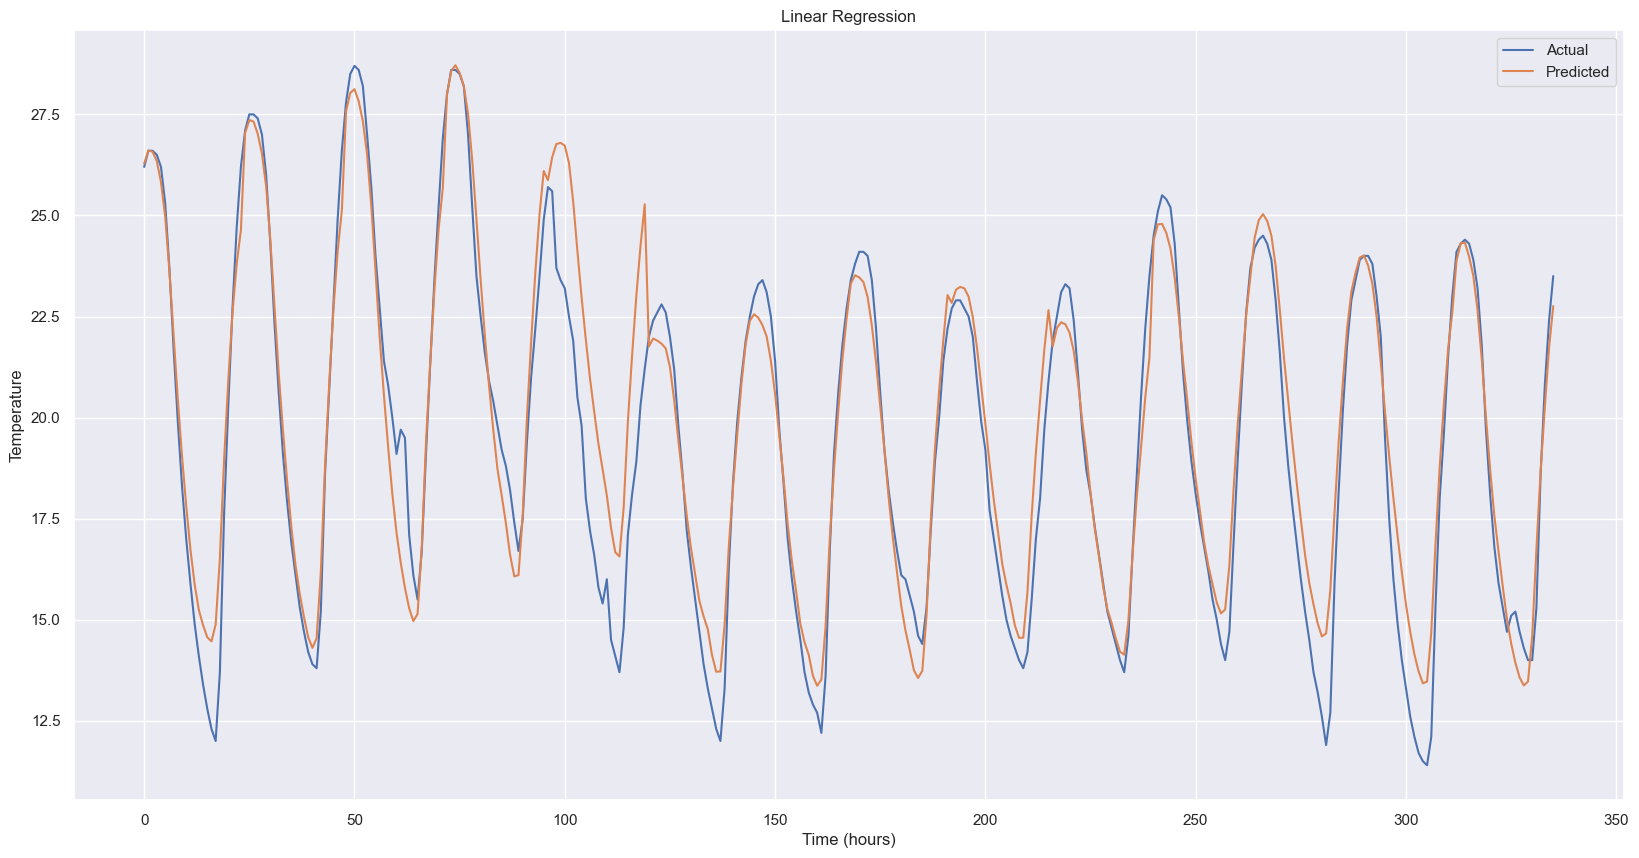

In [12]:
draw(linear_model, 'Linear Regression', test_amount=14, columns=weather.columns)

In [179]:
pickle.dump(linear_model, open('./models/linear', 'wb'))

In [13]:
linear2 = pickle.load(open('./models/linear', 'rb'))
score(linear2, X_test, y_test)

MSE: 5.085668045469233
MAE: 1.5988261291293675
R2: 0.9592734192457394


### Random Forest

In [11]:
weather = load_dataset(columns=['temperature'])
X_train, X_test, y_train, y_test = get_train_test(weather, 144, 24)

random_forest_model = RandomForestRegressor(n_estimators=100, criterion='squared_error')
random_forest_model.fit(X_train, y_train)
score(random_forest_model, X_test, y_test)

MSE: 2.0832905266966075
MAE: 0.7766444610778441
R2: 0.9480254068490682


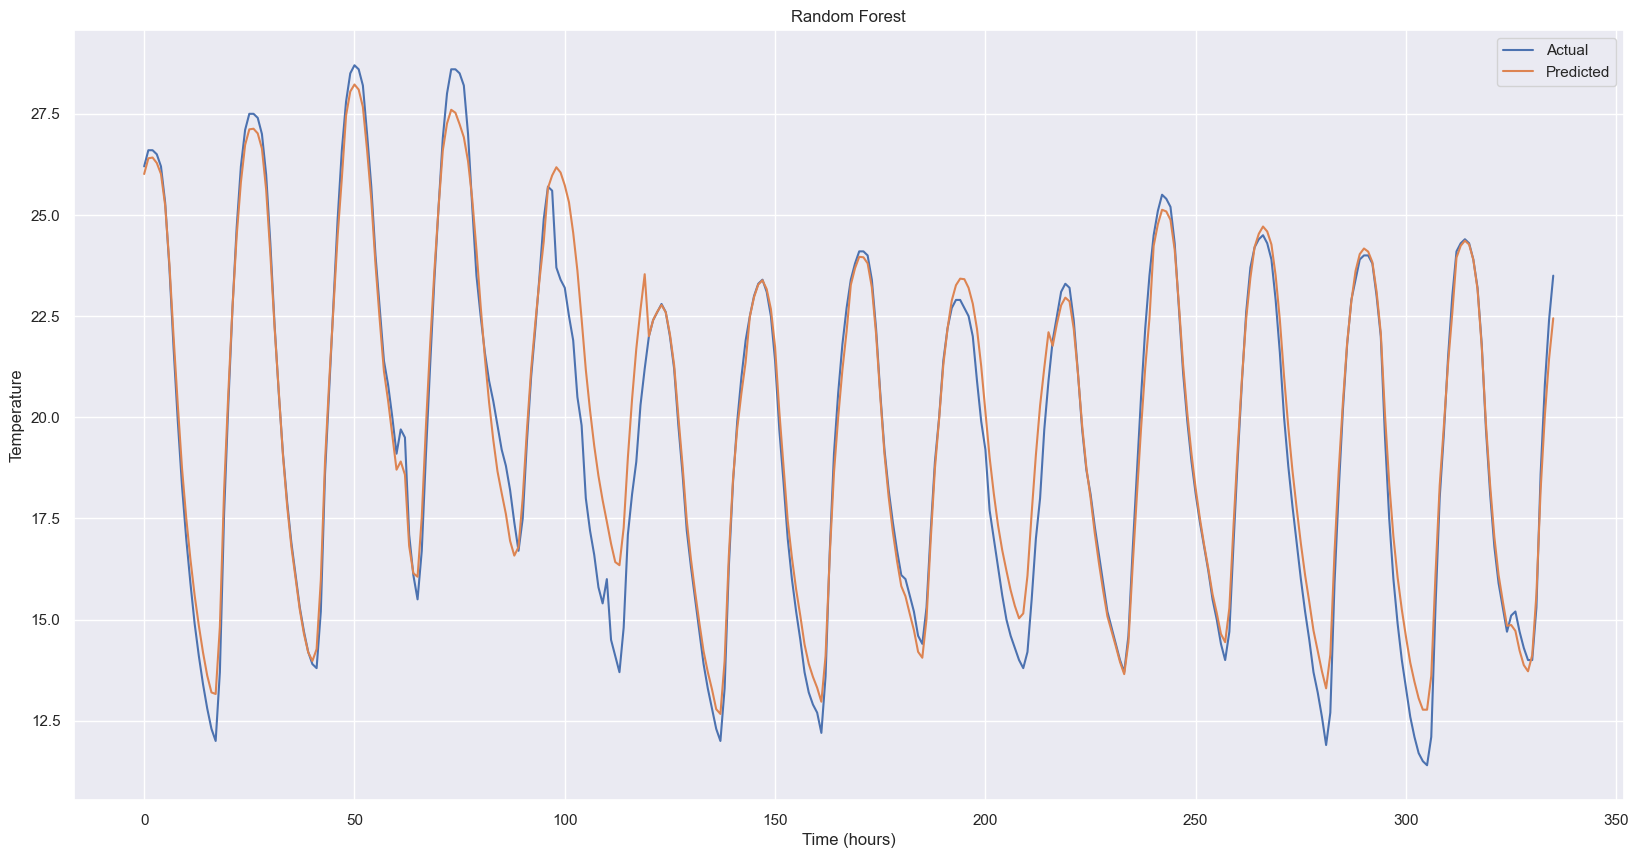

In [243]:
draw(random_forest_model, 'Random Forest', test_amount=14, columns=weather.columns)

In [238]:
pickle.dump(random_forest_model, open('./models/random_forest', 'wb'))

In [ ]:
rft = pickle.load(open('~/models/random_forest', 'rb'))

### XGBoost

In [219]:
weather = load_dataset(columns=['temperature'])
X_train, X_test, y_train, y_test = get_train_test(weather, 144, 24)

dtrain = xgb.DMatrix(X_train, label=y_train.values)
dtest = xgb.DMatrix(X_test, label=y_test.values)

params = {'max_depth': 5, 'eta': 0.1, 'objective': 'reg:squarederror', 'eval_metric': 'mae'}
num_rounds = 100
xgboost_model = xgb.train(params, dtrain, num_rounds)

score(xgboost_model, dtest, y_test)

MSE: 5.5399828162994496
MAE: 1.6978952247115089
R2: 0.9556397698663259


In [220]:
xgboost_model.save_model('./models/xgboost.json')

### Trained XGBoost

In [33]:
booster = xgb.Booster()
booster.load_model('./models/xgboost.json')

In [34]:
weather = load_dataset(columns=['temperature'])
X_train, X_test, y_train, y_test = get_train_test(weather, 144, 24, shuffle=False)

dtest = xgb.DMatrix(X_test, label=y_test.values)

score(booster, dtest, y_test)

MSE: 5.1982334561361165
MAE: 1.6517397114512684
R2: 0.9533521706055628


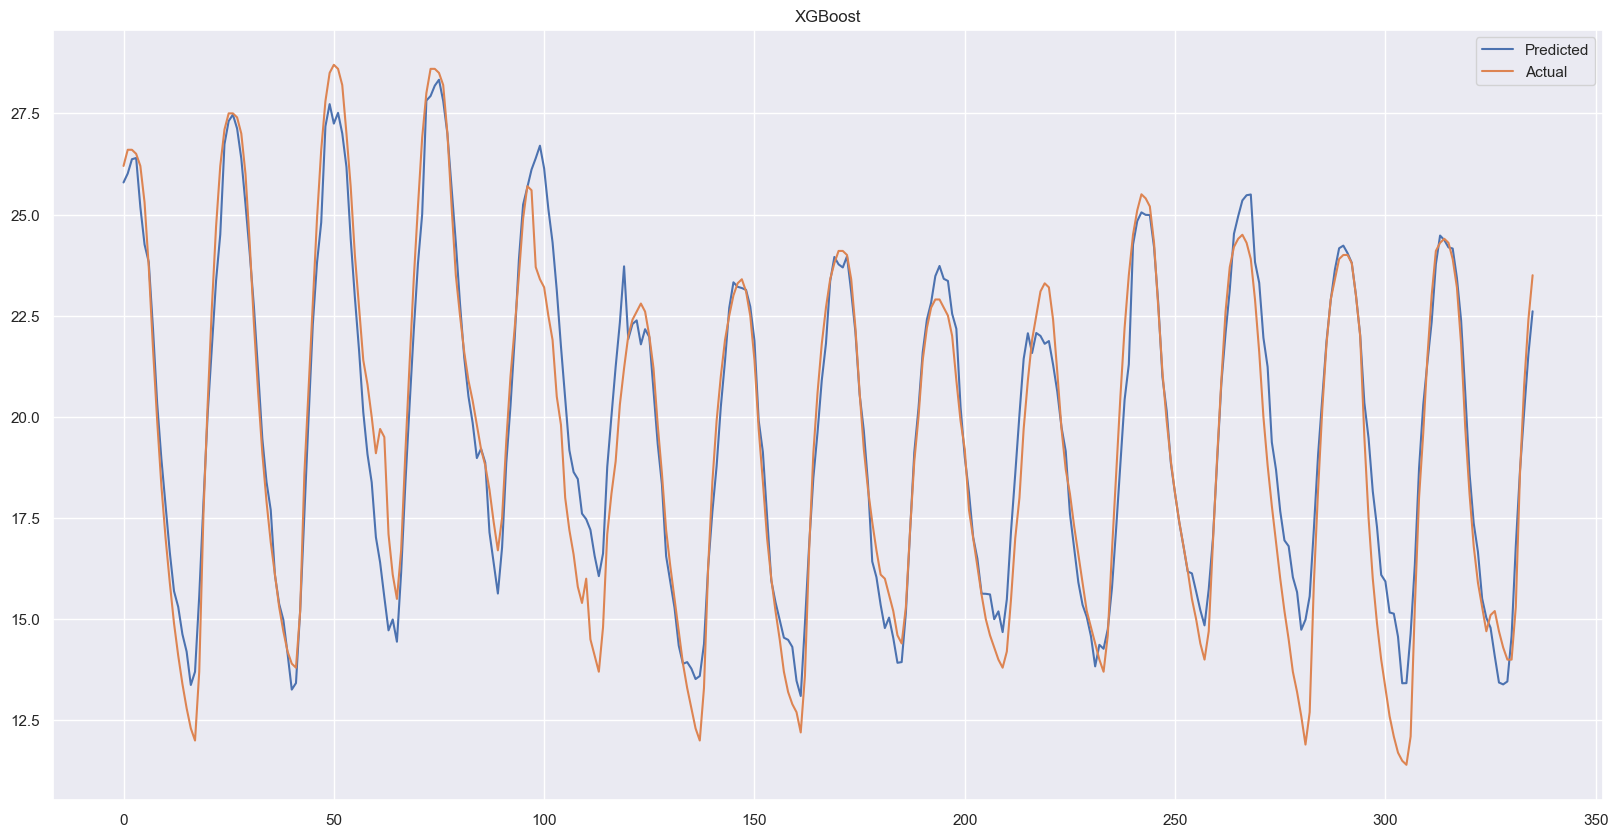

In [35]:
y_pred = booster.predict(dtest)[::24]
y_test = y_test[::24]

plt.plot(y_pred[:14].reshape(1, -1)[0], label='Predicted')
plt.plot(y_test.values[:14].reshape(1, -1)[0], label='Actual')
plt.title('XGBoost')
plt.legend()
plt.show()

### Neural Networks

In [24]:
def draw_nn(model, title, test_amount: int = 7, window_size: int = 144, columns: list[str] = ['temperature'], predict_duration: int = 24):
     weather = load_dataset(columns=columns)

     _, X_test, _, y_test = get_train_test(weather, window_size, predict_duration, shuffle=False)
     scaler = MinMaxScaler()
     X_test_scaled = scaler.fit_transform(X_test)
     X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

     X_test_tensor = X_test_tensor[::predict_duration]
     y_test = y_test[::predict_duration]

     y_pred = model(X_test_tensor)
     if type(y_pred) == tuple:
          y_pred = y_pred[0]
          
     y_test_pred = y_pred.detach().numpy()[:test_amount].reshape(1, -1)[0]
     y_test_actual = y_test.values[:test_amount].reshape(1, -1)[0]

     # Plot the predicted vs. actual temperatures
     sns.set(rc={'figure.figsize': (20, 10)})
     plt.plot(y_test_actual, label='Actual')
     plt.plot(y_test_pred, label='Predicted')
     plt.title(title)
     plt.xlabel('Time (hours)')
     plt.ylabel('Temperature')
     plt.legend()
     plt.show()

### Multilayer Perceptron (MLP)

In [25]:
weather = load_dataset(columns=['temperature'])

X_train, X_test, y_train, y_test = get_train_test(weather, 144, 24)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, y_train.shape[1]), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, y_test.shape[1]), dtype=torch.float32)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


input_dim = X_train.shape[1]
hidden_dim = 24
output_dim = y_train.shape[1]

mlp_model = MLP(input_dim, hidden_dim, output_dim)

criterion = nn.L1Loss()
optimizer = optim.Adagrad(mlp_model.parameters(), lr=0.01)

num_epochs = 5000
for epoch in range(num_epochs):
    optimizer.zero_grad()

    y_pred = mlp_model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        y_pred = mlp_model(X_test_tensor)
        mse = criterion(y_pred, y_test_tensor)
        print(f'Epoch [{epoch+1}/{num_epochs}], MSE: {mse:.4f}')


with torch.no_grad():
    y_pred = mlp_model(X_test_tensor)
    mse = criterion(y_pred, y_test_tensor)
    print(f'MSE: {mse:.4f}')
    print('MAE:', mean_absolute_error(y_pred, y_test_tensor))
    print('R2:', r2_score(y_pred, y_test_tensor))

MSE: 9.3734
MAE: 9.373458
R2: -5921.071243616051


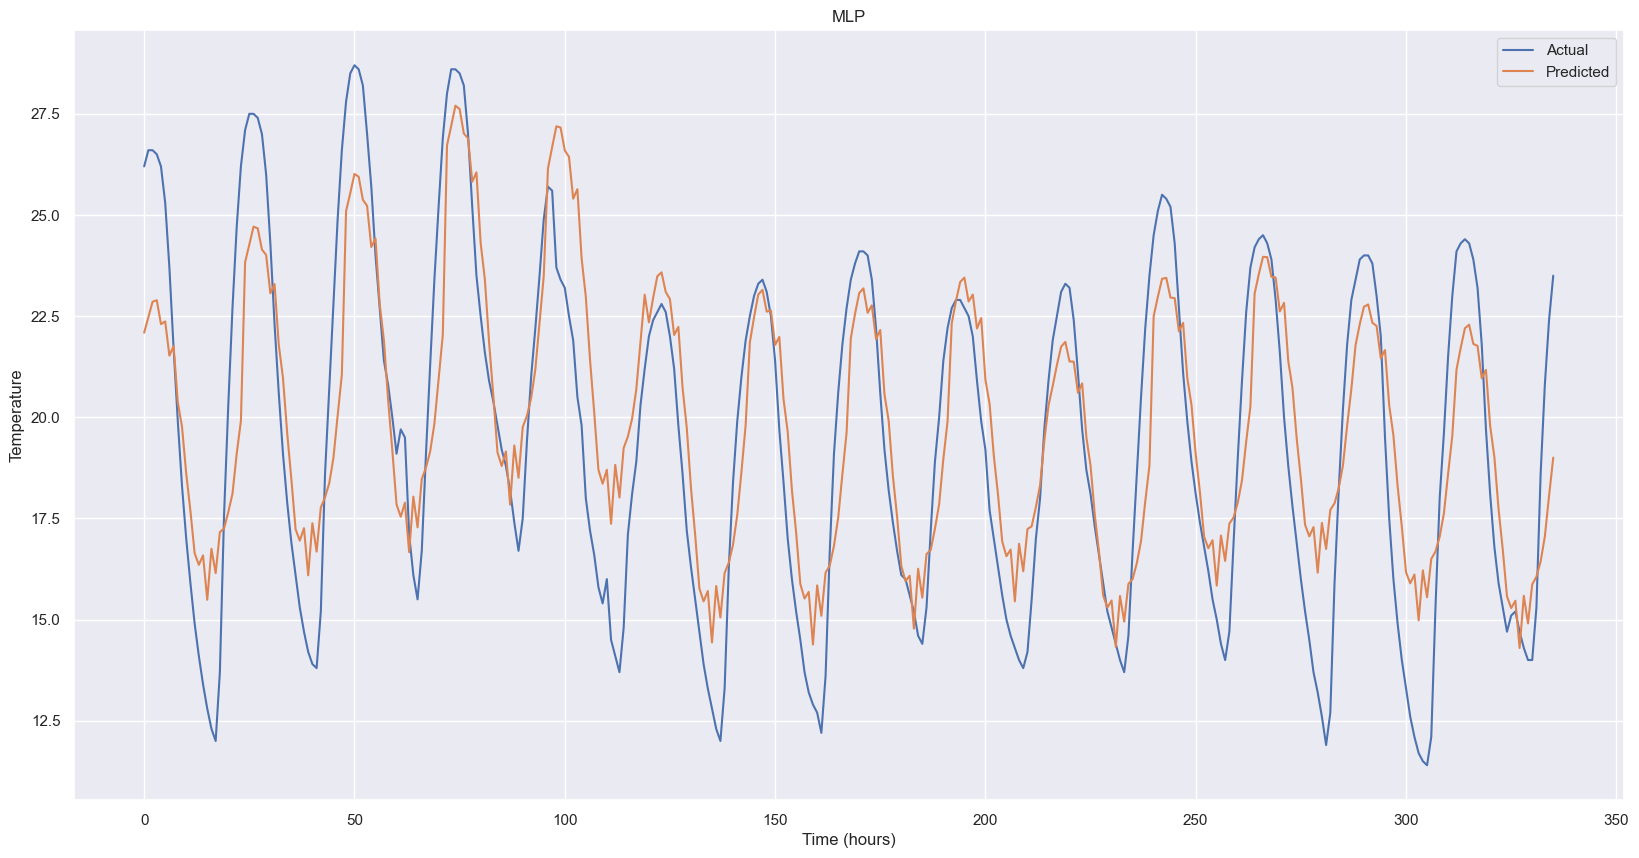

In [19]:
draw_nn(mlp_model, 'MLP', test_amount=14, window_size=144, columns=weather.columns)

In [55]:
torch.save(mlp_model.state_dict(), './models/mlp_h12_5k.json')

### Trained MLP

MSE: 1.8404
MAE: 1.8403997
R2: 0.943338117234866


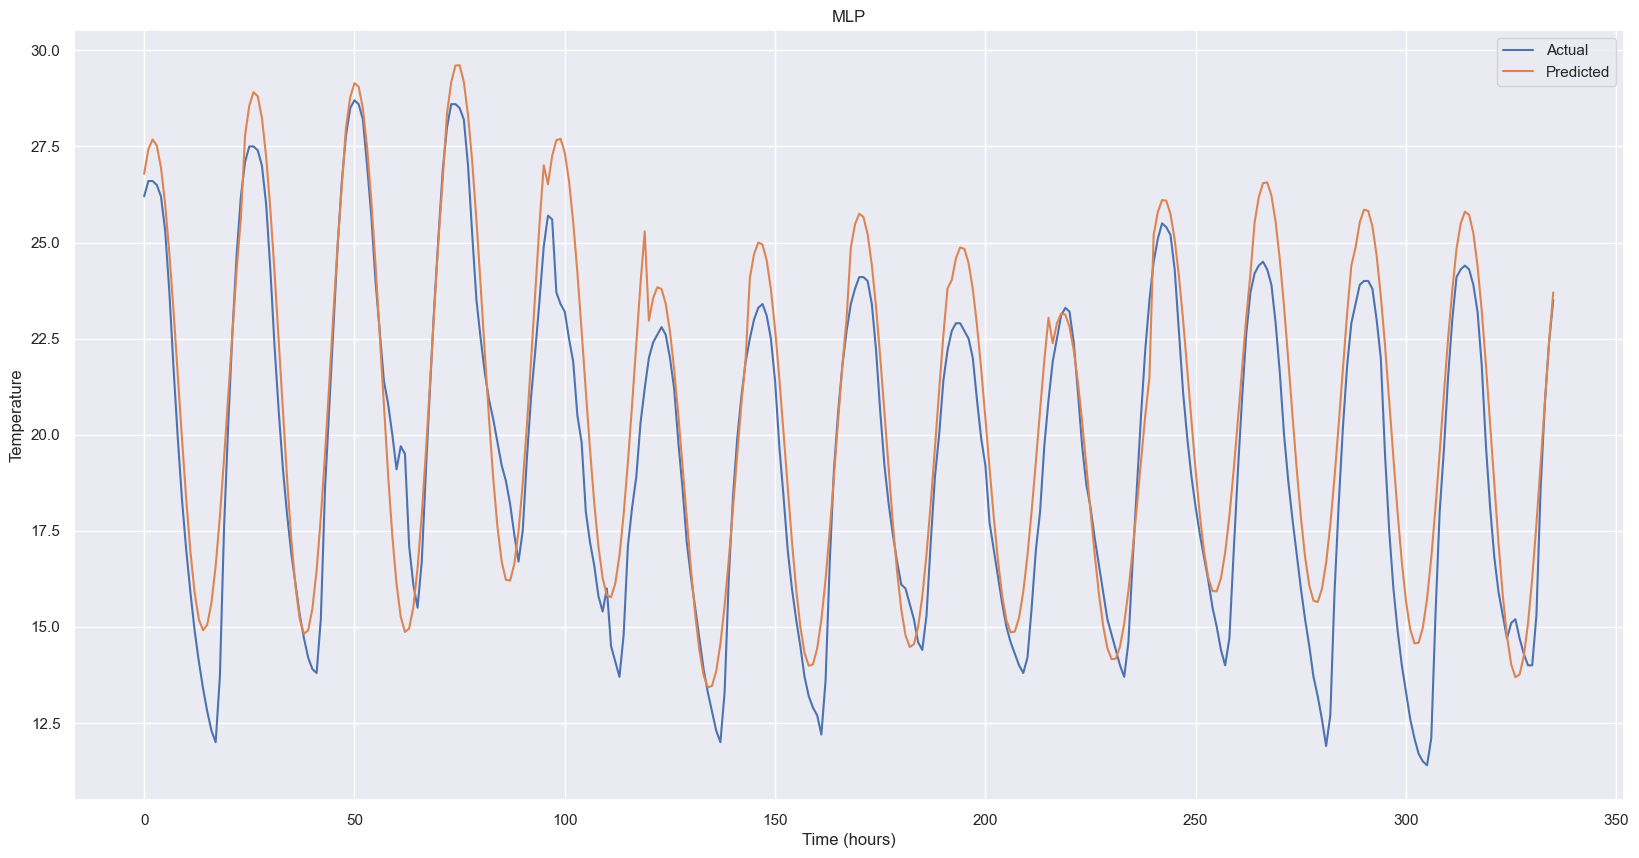

In [26]:
mlp2 = MLP(144, 12, 24)
mlp2.load_state_dict(torch.load('./models/mlp_h12_5k.json'))
with torch.no_grad():
    y_pred = mlp2(X_test_tensor)
    mse = criterion(y_pred, y_test_tensor)
    print(f'MSE: {mse:.4f}')
    print('MAE:', mean_absolute_error(y_pred, y_test_tensor))
    print('R2:', r2_score(y_pred, y_test_tensor))

    
draw_nn(mlp2, 'MLP', test_amount=14, columns=weather.columns)

### RNN

In [27]:
weather = load_dataset(limit=50000, columns=['temperature'])

X_train, X_test, y_train, y_test = get_train_test(weather, 144, 24)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, y_train.shape[1]), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, y_test.shape[1]), dtype=torch.float32)


class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden = None):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden
    
    
input_dim = X_train.shape[1]
hidden_dim = 12
output_dim = y_train.shape[1]

rnn = RNN(input_dim, hidden_dim, output_dim)

criterion = nn.L1Loss()
optimizer = optim.Adam(rnn.parameters(), lr=0.01)

num_epochs = 1000
hidden = None  # initialize hidden state to None

for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred, hidden = rnn(X_train_tensor, hidden)

    loss = criterion(y_pred, y_train_tensor)

    loss.backward()
    optimizer.step()

    if (epoch+1) % 1 == 0:
        y_pred, _ = rnn(X_test_tensor, hidden)  # use the same hidden state for prediction
        mse = criterion(y_pred, y_test_tensor)
        print(f'Epoch [{epoch+1}/{num_epochs}], MSE: {mse:.4f}')

    # update hidden state for next epoch
    hidden = hidden.detach()


with torch.no_grad():
    y_pred, _ = rnn(X_test_tensor, hidden)
    mse = criterion(y_pred, y_test_tensor)
    print(f'MSE: {mse:.4f}')
    print('MAE:', mean_absolute_error(y_pred, y_test_tensor))
    print('R2:', r2_score(y_pred, y_test_tensor))


Epoch [1/1], MSE: 10.0939
MSE: 10.0939
MAE: 10.093864
R2: -85335.12904678042


In [53]:
weather = load_dataset(columns=['temperature'])

X_train, X_test, y_train, y_test = get_train_test(weather, 144, 24)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, y_train.shape[1]), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, y_test.shape[1]), dtype=torch.float32)

with torch.no_grad():
    y_pred, _ = rnn(X_test_tensor, hidden)
    mse = criterion(y_pred, y_test_tensor)
    print(f'MSE: {mse:.4f}')
    print('MAE:', mean_absolute_error(y_pred, y_test_tensor))
    print('R2:', r2_score(y_pred, y_test_tensor))

MSE: 2.3731
MAE: 2.3731167
R2: 0.9165135697607879


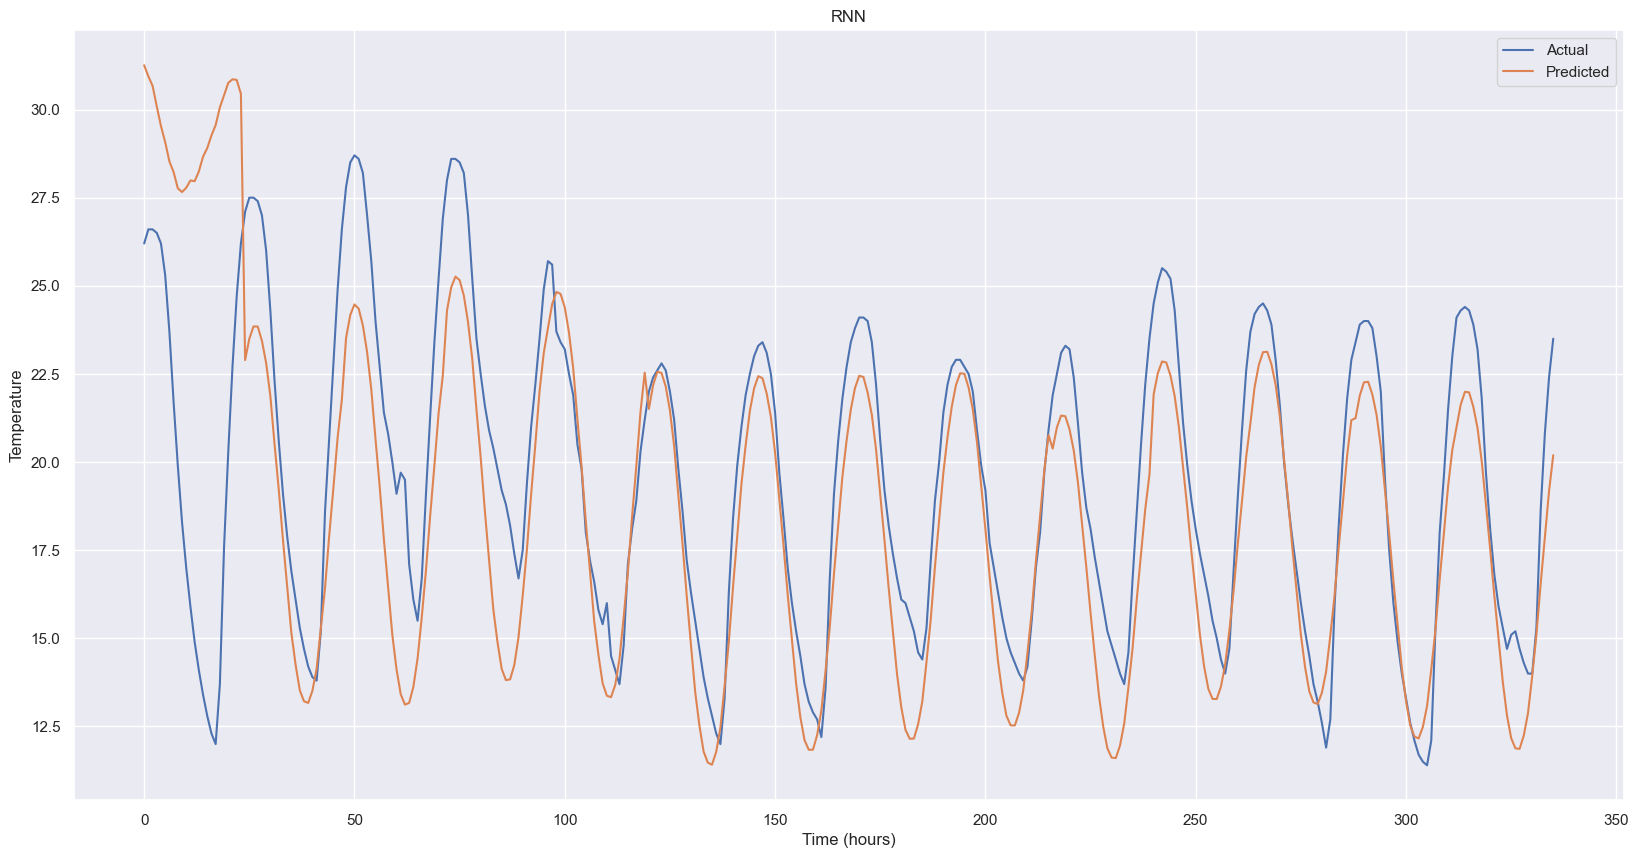

In [51]:
draw_nn(rnn, 'RNN', test_amount=14, columns=weather.columns)

In [49]:
torch.save(rnn.state_dict(), './models/rnn_h24_1k_50kstr.json')

In [31]:
weather = load_dataset(columns=['temperature'])

X_train, X_test, y_train, y_test = get_train_test(weather, 144, 24)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, y_train.shape[1]), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, y_test.shape[1]), dtype=torch.float32)

with torch.no_grad():
    y_pred, _ = rnn(X_test_tensor, hidden)
    mse = criterion(y_pred, y_test_tensor)
    print(f'MSE: {mse:.4f}')
    print('MAE:', mean_absolute_error(y_pred, y_test_tensor))
    print('R2:', r2_score(y_pred, y_test_tensor))

MSE: 10.1530
MAE: 10.153018
R2: -101543.30201279193


### Trained RNN

MSE: 2.3734
MAE: 2.373391
R2: 0.9164840344209285


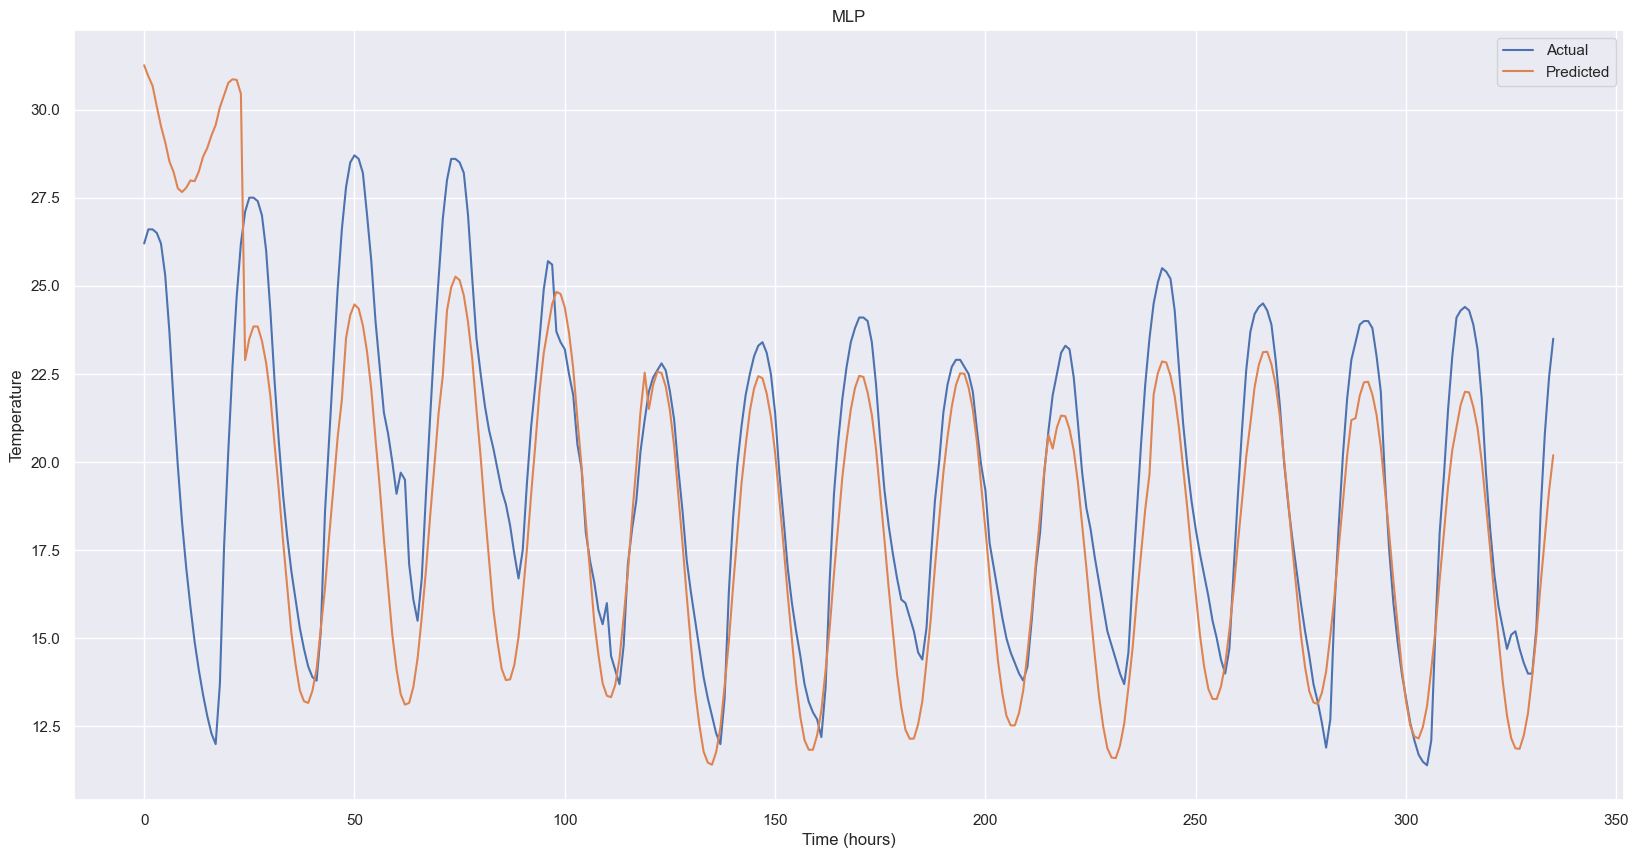

In [32]:
rnn2 = RNN(144, 24, 24)
rnn2.load_state_dict(torch.load('./models/rnn_h24_1k_50kstr.json'))
with torch.no_grad():
    y_pred, _ = rnn2(X_test_tensor)
    mse = criterion(y_pred, y_test_tensor)
    print(f'MSE: {mse:.4f}')
    print('MAE:', mean_absolute_error(y_pred, y_test_tensor))
    print('R2:', r2_score(y_pred, y_test_tensor))

    
draw_nn(rnn2, 'MLP', test_amount=14, columns=weather.columns)